# EG-SWE-Assessment

by Prasheeth Venkat Kumar

## Introduction
Welcome to this CS:GO analysis notebook, where I will address questions from the EG Assessment by providing insights into team strategies, players' location heatmaps, etc. The focus of this assessment revolves around Bombsite B on the map, Overpass. Using the combination of my CS:GO knowledge and Data Science skills, my goal is to provide valuable insights to the coaching staff by analyzing player data from a Counter-Strike match.

- This Jupyter Notebook file is well-organized
    - To have the best viewing experience, please use a Jupyter Notebook environment such as VSCode or the Jupyter Notebook in your browser
    - You can use the outline of this notebook to navigate through its different parts


**Notice: I have made several assumptions regarding my understanding and approach to this assessment:**

- Please note that my approach may change if I had more information regarding the assessment and more practice with CS:GO match game data
- I have utilized a high-end computer build, allowing me to take an approach that fosters creativity

## Data Description
The data provided for this EG Assessment is a Parquet file containing player data during a CS:GO match. The table below will provide deatils regarding the columns present in the data and a descriptoin about them. In addition to the Parquet file, an image of radar/map was provided, (x,y) coordinates for a chokepoint of interest (light blue region) were provided.

| Attribute         | Description                                                  | Type     |
|-------------------|--------------------------------------------------------------|----------|
| round_num         | round                                                        | int      |
| tick              | time unit (128ticks per second)                              | int      |
| side              | T (terrorist) or CT (counterterrorist) that team is playing  | str      |
| team              | team                                                         | str      |
| hp                | current health points                                        | int      |
| armor             | current armor value                                          | int      |
| is_alive          | if player is alive or dead                                   | boolean  |
| x                 | x coordinate                                                 | int      |
| y                 | y coordinate                                                 | int      |
| Z                 | z coordinate                                                 | int      |
| inventory         | what the player is carrying and equipment details            | dict/json|
| total_utility     | number of utility (grenades, flashes, smokes, inced)         | int      |
| equipment_value_freezetime_end | value of equipment after purchase time ends         | int      |
| area_name         | location that the player is                                  | str      |
| seconds           | elapsed time (resets to zero after bomb plant)               | int      |
| clock_time        | in-game clock timer (resets to 0:40 after bomb plant)        | str      |
| t_alive           | number of T alive                                            | int      |
| ct_alive          | number of CT alive                                           | int      |
| bomb_planted      | if the bomb has been planted yet                             | boolean  |
| map_name          | map being played                                             | str      |
| utility_used      | number of utility used                                       | int      |
| player            | player name                                                  | str      |

## Part 1

**Question:**
> Write a Python class called `ProcessGameState` that will accomplish the following:

> a. Handle file ingestion and ETL (if deemed necessary).

> b. Reduce dependencies outside of standard Python libraries unless you can prove significant improvements.

> c. Extract the weapon classes from the inventory JSON column.

**Notes**:
- For the `ProcessGameState` class, I have decided to take a "static" approach since it allows for handling data in a more intuitive and efficient manner. Previously, I tried using a "dynamic" approach to my class design; however, it created unnecessary complications. This iteration of the `ProcessGameState` class acts as a "helper" class that facilitates easy data manipulation and creation.


In [1]:
import pandas as pd
import json
import pyarrow
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans

In [2]:
class ProcessGameState:
    def __init__(self):
        """
        Initializes the ProcessGameState class.

        This constructor prints a message indicating that the class has been created.
        """
        print("Created Class")
        
    def load_data(self, file_path):
        """
        Loads data from a Parquet file.

        Args:
            file_path (str): The path to the Parquet file contaning the CS:GO match data.

        Returns:
            pandas.DataFrame: The loaded data as a pandas DataFrame.
        """
        return pd.read_parquet(file_path, engine='pyarrow')

        
    def create_boundary_polygon(self, xy_boundary_coordinates, z_bounds):
        """
        Creates a boundary polygon for the xy-coordinates and sets z bounds.

        Args:
            xy_boundary_coordinates (list): List of (x, y) coordinates defining the boundary polygon.
            z_bounds (list): List of two values representing the minimum and maximum z bounds.
        """
        self.xy_boundary_polygon = Polygon(xy_boundary_coordinates)
        self.z_min = z_bounds[0]
        self.z_max = z_bounds[1]
    
    def is_row_in_boundary(self, row):
        """
        Checks if a given row is within the defined boundary polygon and z bounds.

        Args:
            row: A row from the data.

        Returns:
            bool: True if the row is within the boundary and z bounds, False otherwise.
        """
        is_within_xy_boundary_polygon = self.xy_boundary_polygon.contains(Point(row.x, row.y))
        is_within_z_bounds = self.z_min <= row.z <= self.z_max
        return is_within_xy_boundary_polygon and is_within_z_bounds
    
    def create_custom_boundary_polygon(self, xy_boundary_coordinates, z_bounds):
        """
        Creates a custom boundary polygon for the xy-coordinates and sets z bounds.

        Args:
            xy_boundary_coordinates (list): List of (x, y) coordinates defining the custom boundary polygon.
            z_bounds (list): List of two values representing the minimum and maximum z bounds.
        """
        num_vertices = len(xy_boundary_coordinates)
        polygon = []

        for i in range(num_vertices):
            x, y = xy_boundary_coordinates[i]
            polygon.append((x, y))

        self.custom_xy_boundary_polygon =  polygon
        self.z_min = z_bounds[0]
        self.z_max = z_bounds[1]
    
    def is_row_in_custom_boundary(self, row):
        """
        Checks if a given row is within the custom boundary polygon and z bounds.

        Args:
            row: A row from the data.

        Returns:
            bool: True if the row is within the custom boundary and z bounds, False otherwise.
        """
        x = row.x
        y = row.y

        num_vertices = len(self.custom_xy_boundary_polygon)
        wn = 0

        for i in range(num_vertices):
            x1, y1 = self.custom_xy_boundary_polygon[i]
            x2, y2 = self.custom_xy_boundary_polygon[(i + 1) % num_vertices]

            if y1 <= y:
                if y2 > y and self._is_left(x1, y1, x2, y2, x, y) > 0:
                    wn += 1
            else:
                if y2 <= y and self._is_left(x1, y1, x2, y2, x, y) < 0:
                    wn -= 1

        is_within_z_bounds = self.z_min <= row.z <= self.z_max

        return wn != 0 and is_within_z_bounds
    
    @staticmethod
    def _is_left(x1, y1, x2, y2, x, y):
        """
        Determines the relationship between three points and returns a value indicating whether the third point
        is on the left or right side of the line formed by the first two points.

        Args:
            x1 (float): x-coordinate of the first point.
            y1 (float): y-coordinate of the first point.
            x2 (float): x-coordinate of the second point.
            y2 (float): y-coordinate of the second point.
            x (float): x-coordinate of the third point.
            y (float): y-coordinate of the third point.

        Returns:
            float: The value indicating the relative position of the third point to the line formed by the first two points.
        """
        return (x2 - x1) * (y - y1) - (x - x1) * (y2 - y1)
    
    
    def extract_weapon_classes(self, row):
        """
        Extracts weapon classes from a given row.

        Args:
            row: A row from the CS:GO Pandas Dataframe.

        Returns:
            dict: A dictionary containing weapon classes as keys and weapon names as values.
        """
        weapon_classes ={}
        if row.inventory is not None:
            weapon_classes = {item['weapon_class']: item['weapon_name'] for item in row.inventory}
        return weapon_classes
    
    def has_heavy_weapon_class(self, row):
        """
        Checks if a given row contains a heavy weapon class by checking if the row contains a Rifle or SMG.

        Args:
            row: A row from the CS:GO Pandas Dataframe.

        Returns:
            int: 1 if the row contains a heavy weapon class (Rifle or SMG), 0 otherwise.
        """
        weapon_classes = self.extract_weapon_classes(row)
        if 'Rifle' in weapon_classes or 'SMG' in weapon_classes:
            return 1
        
        return 0




#### Section 1: Handle file ingestion

**Notes:**
- The `ProcessGameState` class' `load_data` method handles file ingestion for the CS:GO match game data Parquet file
    - The "load_data" method uses the PyArrow engine to load the data and converts it into a Pandas DataFrame
        - Converting the Parquet data to Pandas allows for efficient workability with large data
    - Since the class takes a "static" approach, the Pandas DataFrame is returned rather than being stored

In [3]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()

# Read the CS:GO game state data, parquet file 
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()


Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


#### Data Analysis

- In this section, I will be exploring various columns from the dataframe to gain further insight.
    - Certain columns were chosen because they contain interesting information regarding the assessment questions, while others require further context.
    - This section will help in approaching the solutions for questions 1.B and 1.C (Section B and Section C).

In [4]:
# Print team names
print(f"Information about the teams: {game_state_df.team.unique()}")

Information about the teams: ['Team1' 'Team2']


In [5]:
# Print the number of unique players
print(f"Number of unique players: {len(game_state_df.player.unique())}")

Number of unique players: 10


In [6]:
# Print the number of unique rounds
print(f"Number of unique rounds: {game_state_df.round_num.unique()}")

Number of unique rounds: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30]


In [7]:
# Print the some basic information about the location columns: x, y, z
print(f"Information about the x column: {game_state_df.x.describe()}")
print(f"Information about the y column: {game_state_df.y.describe()}")
print(f"Information about the z column: {game_state_df.z.describe()}")

Information about the x column: count    221330.000000
mean      -1819.130665
std         900.465391
min       -3960.000000
25%       -2439.000000
50%       -1857.000000
75%       -1007.000000
max         -49.000000
Name: x, dtype: float64
Information about the y column: count    221330.000000
mean       -654.268468
std        1036.420364
min       -3401.000000
25%       -1322.000000
50%        -523.000000
75%         162.000000
max        1606.000000
Name: y, dtype: float64
Information about the z column: count    221330.000000
mean        273.244215
std         185.746748
min           0.000000
25%          96.000000
50%         273.000000
75%         472.000000
max         618.000000
Name: z, dtype: float64


In [8]:
# Print the informaiton about the map name
print(f"Information about the map name: {game_state_df.map_name.describe()}")

Information about the map name: count          221330
unique              1
top       de_overpass
freq           221330
Name: map_name, dtype: object


In [9]:
# Print the unique values of the area name
print(f"Unique values of the area name: {game_state_df.area_name.unique()}")

Unique values of the area name: ['TSpawn' 'TStairs' 'Tunnels' 'Fountain' 'LowerPark' 'Playground' 'Alley'
 'Connector' 'BombsiteA' 'Canal' 'Pipe' 'Water' 'Construction' 'UpperPark'
 'Restroom' 'Lobby' 'StorageRoom' 'SnipersNest' 'BackofA' 'Stairs'
 'UnderA' 'Walkway' 'Bridge' 'BombsiteB' None 'SideAlley']


In [10]:
# Print to see what the inventory column looks like
print(f"Information about the inventory column: {game_state_df.inventory.head(1).values}")

Information about the inventory column: [array([{'ammo_in_magazine': 20, 'ammo_in_reserve': 120, 'weapon_class': 'Pistols', 'weapon_name': 'Glock-18'},
        {'ammo_in_magazine': 1, 'ammo_in_reserve': 0, 'weapon_class': 'Grenade', 'weapon_name': 'Decoy Grenade'}],
       dtype=object)                                                                                              ]


In [11]:
# Print to all the unuiqe weapon classes in the inventory column
inventory_df = game_state_df['inventory']

keys = set()
for dictionary in inventory_df:
    if dictionary is not None:
        for key in dictionary:
            keys.add(key['weapon_class'])
print(keys)

{'SMG', 'Grenade', 'Rifle', 'Pistols'}


#### Section B: Check whether or not each row falls within a provided boundary

> Be as efficient as possible (minimize runtime)

> Reduce dependencies outside of standard Python libraries unless
you can prove significant improvements

**Notes:**
- Based on my research, to achieve optimal efficiency for a point-in-polygon algorithm, we need to consider the third-party library: Shapely.
- However, since the goal of this question is to minimize dependencies outside of the standard Python libraries, I will develop a custom point-in-polygon algorithm.
- The objective is to compare two strategies for processing data and determine which one performs better.
    - Considering the dataset is relatively small, both algorithms may perform similarly.
    - However, it is important to note that if the dataset were larger, the Shapely library would significantly outperform the custom point-in-polygon algorithm.
    - Additionally, if a different or more complex polygon region was chosen for analysis, the Shapely library would also significantly outperform the custom algorithm.

##### Strategy 1: Shapely's Point-In-Polygon Algorithm

Reference: https://www.matecdev.com/posts/point-in-polygon.html

In [12]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()

# Read the CS:GO game state data, parquet file 
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()


Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [13]:
# Enter X_Y coordinate array
input_xy_coordinate_array = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580]]
# Enter Z bounds
input_z_bounds = [285, 421]
# Create a boundary polygon using Shapeley's PIP algorithm
process_game_state.create_boundary_polygon(xy_boundary_coordinates=input_xy_coordinate_array, z_bounds=input_z_bounds)
# Print row 1 x,y,z coordinates
display(game_state_df.iloc[0][['x', 'y', 'z']])
# Print: check whether or not the first row is in the boundary
print(f"Is the first row in the boundary: {process_game_state.is_row_in_boundary(game_state_df.iloc[0])}")

x    -1310
y    -3333
z      294
Name: 0, dtype: object

Is the first row in the boundary: False


In [14]:
%%time
# Calculate whether or not each row is in the boundary
game_state_df['in_boundary'] = game_state_df.apply(lambda x: process_game_state.is_row_in_boundary(x) , axis=1)
print(game_state_df['in_boundary'].value_counts())

False    220498
True        832
Name: in_boundary, dtype: int64
Wall time: 9.52 s


##### Strategy 2: Custom Winding Number Algorithm for Point-In-Polygon

Reference: https://towardsdatascience.com/is-the-point-inside-the-polygon-574b86472119

In [15]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()

# Read the CS:GO game state data, parquet file 
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()


Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [16]:
# Enter X_Y coordinate array
input_xy_coordinate_array = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580]]
# Enter Z bounds
input_z_bounds = [285, 421]
# Create a boundary polygon using Winding Number algorithm
process_game_state.create_custom_boundary_polygon(xy_boundary_coordinates=input_xy_coordinate_array, z_bounds=input_z_bounds)
# Print row 1 x,y,z coordinates
display(game_state_df.iloc[0][['x', 'y', 'z']])
# Print: check whether or not the first row is in the boundary
print(f"Is the first row in the boundary: {process_game_state.is_row_in_custom_boundary(game_state_df.iloc[0])}")

x    -1310
y    -3333
z      294
Name: 0, dtype: object

Is the first row in the boundary: False


In [17]:
%%time
# Calculate whether or not each row is in the boundary
game_state_df['in_boundary'] = game_state_df.apply(lambda x: process_game_state.is_row_in_custom_boundary(x) , axis=1)
print(game_state_df['in_boundary'].value_counts())

False    220498
True        832
Name: in_boundary, dtype: int64
Wall time: 4.43 s


##### Conclusion

- The custom Winding Number Algorithm for Point-In-Polygon performed significantly better than Shapely's PIP algorithm.
    - Shapely's PIP algorithm took 9.59 seconds for all the rows in the dataset.
    - The custom Winding Number Algorithm for PIP took 4.24 seconds for all the rows in the dataset.
    - The better performance is likely due to the simplicity of the given polygon.

#### Section C: Extract the weapon classes from the inventory JSON column

- The `ProcessGameState` class's method `extract_weapon_class` extracts the weapon classes in a dictionary format from a single row.

In [18]:
# Print the extraced weapon class of the first row
print(f"Information about the inventory column: {process_game_state.extract_weapon_classes(game_state_df.iloc[0])}")

Information about the inventory column: {'Pistols': 'Glock-18', 'Grenade': 'Decoy Grenade'}


***

## Part 2

> Using the created class, answer the following questions:

> a. Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?

> b. What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs?

> c. Now that we’ve gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching staff where you suspect them to be waiting inside “BombsiteB”

**Notes:**
- The `ProcessGameState` class should have the appropriate methods that aid in answering the questions.
- In this section, I have relied on my Counter-Strike knowledge to provide context and clarity regarding trends and insights.

 #### Section 1: 

 > is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?

 ![overpass radar with chokepoint](overpass_w_boundaries.png)

The coordinate details are as follows:
● Z-Axis Bounds: 285 <= Z <= 421
● 13: [-1735, 250]
● 14: [-2024, 398]
● 15: [-2806, 742]
● 16: [-2472, 1233]
● 17: [-1565, 580]

**Notes:**
- What area is actually covered by the light blue boundary?
    - The "light blue boundary" does not cover the A bombsite but rather the area underneath it due to the 3-D bounds.
    - Familiarity with the Overpass map helps identify the specific areas covered by the boundary, such as the "back of A", "snipersnest", etc.
- The question asks if the Ts (Terrorists) of Team 2 commonly enter this boundary.
    - Based on the Overpass map and player rotation knowledge, it is unusual for Ts to enter an area heavily controlled by CTs (Counter-Terrorists).
        - The boundary's proximity to the CT spawn point suggests that the CTs have better control over it.
    - Without analyzing the actual data, the prediction is that Ts would rarely enter this boundary, potentially less than 2 rounds.

In [19]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()
# Load the data and set the respective boundaries
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()


Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [20]:
# Enter X_Y coordinate array
input_xy_coordinate_array = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580]]
# Enter Z bounds
input_z_bounds = [285, 421]
# Create a boundary polygon using Shapeley's PIP algorithm
process_game_state.create_boundary_polygon(xy_boundary_coordinates=input_xy_coordinate_array, z_bounds=input_z_bounds)

In [21]:
# Apply initial filter
filtered_data = game_state_df[(game_state_df['team'] == 'Team2')
                              & (game_state_df['side'] == 'T')
                                & (game_state_df['is_alive'] == True)
                              ].copy()

# print shape of unfiltered data
print(f"Shape of unfiltered data: {game_state_df.shape}")
# print shape of filtered data
print(f"Shape of filtered data: {filtered_data.shape}")

filtered_data.head()


Shape of unfiltered data: (221330, 22)
Shape of filtered data: (40880, 22)


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
77550,16,286888,T,Team2,100,100,True,-1310,-3332,294,...,950,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5
77551,16,286904,T,Team2,100,100,True,-1303,-3319,293,...,950,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5
77552,16,286920,T,Team2,100,100,True,-1293,-3297,291,...,950,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5
77553,16,286936,T,Team2,100,100,True,-1280,-3272,289,...,950,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5
77554,16,286952,T,Team2,100,100,True,-1267,-3245,286,...,950,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player5


In [22]:
# Apply in boundary filter
filtered_data['in_boundary'] = filtered_data.apply(lambda x: process_game_state.is_row_in_boundary(x) , axis=1)
filtered_data.head()

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,in_boundary
77550,16,286888,T,Team2,100,100,True,-1310,-3332,294,...,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5,False
77551,16,286904,T,Team2,100,100,True,-1303,-3319,293,...,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5,False
77552,16,286920,T,Team2,100,100,True,-1293,-3297,291,...,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5,False
77553,16,286936,T,Team2,100,100,True,-1280,-3272,289,...,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player5,False
77554,16,286952,T,Team2,100,100,True,-1267,-3245,286,...,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player5,False


In [23]:
# Group by round number and in boundary
filtered_data = (filtered_data[filtered_data['in_boundary'] == True].groupby(['round_num','in_boundary'])
 .agg({'player':'nunique'}))
filtered_data

,,player
round_num,in_boundary,
16,True,2


In [24]:
# Print the total numbers of rounds played by Team2 on T side
total_num_rounds = game_state_df[(game_state_df['team'] == 'Team2')
                                 & (game_state_df['side'] == 'T')]['round_num'].nunique()
print(f"Team2's total number of T side rounds: {total_num_rounds}")
# Print the total numbers of rounds played by Team2 on T side where they entered the respective light-blue boundary
num_rounds_entered_blue_region = filtered_data.shape[0]
print(f"Team2's total number of T side rounds where they entered the respective light-blue boundary: {num_rounds_entered_blue_region}")
print(f"On Team2's T side, they entered the ligh-blue boundary {num_rounds_entered_blue_region} out of {total_num_rounds} rounds({(num_rounds_entered_blue_region/total_num_rounds) * 100}%)")

Team2's total number of T side rounds: 15
Team2's total number of T side rounds where they entered the respective light-blue boundary: 1
On Team2's T side, they entered the ligh-blue boundary 1 out of 15 rounds(6.666666666666667%)


##### Conclusion

- Team2 entered the light blue boundary on their T side in only 1 out of 15 rounds
    - This accounts for approximately 6.67% of their T side rounds
- Therefore, entering via the light blue boundary is not a common strategy used by Team2 on their T side
    - This aligns with the expectation that the light blue boundary is typically heavily controlled by the CTs
        - The area covered by the light blue boundary is in close proximity to the CT spawn area, indicating better CT control


### Section 2:

> What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs?

<img src="overpass_bombsiteB.jpg" alt="Overpass Bombsite B" width="400" height="300">

**Notes:**
- What is considered "BombsiteB" in the map of Overpass?
    - Ts typically can enter BombsiteB from short, canal (monster), etc.
        - Are these parts considered as part of BombsiteB?
    - After exploring the dataframe during the earlier data analysis section, I'm inclined to filter the column "area name" by 'BombsiteB'.
- What is considered "Entering (enters)" the "BombsiteB"?
    - Based on intuition and understanding, the criterion for considering Ts to have "entered" is when their area location is set to "BombsiteB" with early elapsed time (seconds).
    - The early time of entry is significant because the Ts may have entered the bombsite but took additional time to plant the bomb, which could disrupt the average timer.
    - Considering the specific area location and the timing of entry helps provide a more accurate assessment of when the Ts have successfully entered the bombsite.
- How to address the "at least 2 rifles or SMGs" aspect of the question?
    - Use the `ProcessGameState` class's method `has_heavy_weapon_class`, which encapsulates the `extract_weapon_class` method, to determine if a row's inventory has a Rifle or SMG.

In [25]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()
# Load the data and set the respective boundaries
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()

Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [26]:
# Apply initial filter
filtered_data = (game_state_df[(game_state_df['area_name'] == 'BombsiteB')
                       &(game_state_df['side'] == 'T')
                       &(game_state_df['team'] == 'Team2')
                       &(game_state_df['bomb_planted']==False)
                       &(game_state_df['is_alive'] == True)
                       ]).copy()
# Create new column: has_heavy_weapon_class that returns 1 if the player has a Rifle or SMG weapon class per row
filtered_data['has_heavy_weapon_class'] = filtered_data.apply(lambda x: process_game_state.has_heavy_weapon_class(x), axis=1)
filtered_data

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,has_heavy_weapon_class
77956,16,293384,T,Team2,100,100,True,-724,-3,50,...,BombsiteB,51,01:05,4,3,False,de_overpass,0.0,Player5,0
77957,16,293400,T,Team2,100,100,True,-736,25,56,...,BombsiteB,51,01:05,4,3,False,de_overpass,0.0,Player5,0
77958,16,293416,T,Team2,100,100,True,-746,53,61,...,BombsiteB,51,01:04,4,3,False,de_overpass,0.0,Player5,0
77959,16,293432,T,Team2,100,100,True,-756,82,66,...,BombsiteB,51,01:04,4,3,False,de_overpass,0.0,Player5,0
77960,16,293448,T,Team2,100,100,True,-769,109,73,...,BombsiteB,51,01:04,4,3,False,de_overpass,0.0,Player5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220031,28,484412,T,Team2,72,100,True,-1092,272,70,...,BombsiteB,42,01:13,2,2,False,de_overpass,0.0,Player9,1
220032,28,484428,T,Team2,72,100,True,-1104,279,64,...,BombsiteB,42,01:13,2,2,False,de_overpass,0.0,Player9,1
220033,28,484444,T,Team2,72,100,True,-1109,289,62,...,BombsiteB,42,01:13,2,2,False,de_overpass,0.0,Player9,1
220034,28,484460,T,Team2,72,100,True,-1109,302,62,...,BombsiteB,42,01:13,2,2,False,de_overpass,0.0,Player9,1


In [27]:
# Sum up the total number of heavy weapon classes per round and tick
filtered_data['total_heavy_weapon_classes'] = filtered_data.groupby(['round_num', 'tick'])['has_heavy_weapon_class'].transform('sum')
filtered_data

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,has_heavy_weapon_class,total_heavy_weapon_classes
77956,16,293384,T,Team2,100,100,True,-724,-3,50,...,51,01:05,4,3,False,de_overpass,0.0,Player5,0,0
77957,16,293400,T,Team2,100,100,True,-736,25,56,...,51,01:05,4,3,False,de_overpass,0.0,Player5,0,0
77958,16,293416,T,Team2,100,100,True,-746,53,61,...,51,01:04,4,3,False,de_overpass,0.0,Player5,0,0
77959,16,293432,T,Team2,100,100,True,-756,82,66,...,51,01:04,4,3,False,de_overpass,0.0,Player5,0,0
77960,16,293448,T,Team2,100,100,True,-769,109,73,...,51,01:04,4,3,False,de_overpass,0.0,Player5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220031,28,484412,T,Team2,72,100,True,-1092,272,70,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2
220032,28,484428,T,Team2,72,100,True,-1104,279,64,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2
220033,28,484444,T,Team2,72,100,True,-1109,289,62,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2
220034,28,484460,T,Team2,72,100,True,-1109,302,62,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2


In [28]:
# Filter by if Team2 has at least 2 heavy weapon classes per round 
filtered_data = filtered_data[
    (filtered_data['total_heavy_weapon_classes']>=2)
]
filtered_data

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,has_heavy_weapon_class,total_heavy_weapon_classes
87154,28,483148,T,Team2,100,100,True,-671,76,23,...,32,01:23,4,3,False,de_overpass,0.0,Player5,1,2
87161,28,483260,T,Team2,100,100,True,-736,248,56,...,33,01:22,4,3,False,de_overpass,0.0,Player5,1,2
87162,28,483276,T,Team2,100,100,True,-756,263,66,...,33,01:22,4,3,False,de_overpass,-1.0,Player5,1,2
87163,28,483292,T,Team2,100,100,True,-778,275,77,...,33,01:22,4,3,False,de_overpass,0.0,Player5,1,2
87164,28,483308,T,Team2,100,100,True,-803,281,89,...,33,01:22,4,3,False,de_overpass,0.0,Player5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220031,28,484412,T,Team2,72,100,True,-1092,272,70,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2
220032,28,484428,T,Team2,72,100,True,-1104,279,64,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2
220033,28,484444,T,Team2,72,100,True,-1109,289,62,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2
220034,28,484460,T,Team2,72,100,True,-1109,302,62,...,42,01:13,2,2,False,de_overpass,0.0,Player9,1,2


In [29]:
# Pick the early seconds since that is when the players are "entering" the bombsite
filtered_data = filtered_data.groupby('round_num').agg({'seconds': 'min', 'player':'nunique', 'total_heavy_weapon_classes': 'max'}).reset_index()
# filtered_data = filtered_data.groupby('round_num')['seconds'].min().reset_index()
filtered_data

,round_num,seconds,player,total_heavy_weapon_classes
0,28,29,5,3


In [30]:
# Determine the mean of the seconds column
avg_seconds = filtered_data['seconds'].mean()
print(f"The average timer for Team2 on T side to enter 'BombsiteB' with at least 2 rifles or SMGs is {avg_seconds} seconds.")

The average timer for Team2 on T side to enter 'BombsiteB' with at least 2 rifles or SMGs is 29.0 seconds.


##### Conclusion

- The average timer for Team2 on T side to enter 'BombsiteB' with at least 2 rifles or SMGs is 29.0 seconds
    - The filtering process might be too harsh since only round statified the condition
        - Take the result with a grain of salt
    - In the future, expanding the filter of the area_name column to 'BackofA', 'Walkway', and 'UnderA' would be viable to increase sample size

### Section 3:

> Now that we’ve gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching staff where you suspect them to be waiting inside “BombsiteB”

<img src="overpass_bombsiteB2.jpg" alt="Overpass Bombsite B" width="500" height="300">

**Notes:**
- The use of the term "waiting" suggests that the bomb has not been planted yet, as the positioning of CTs would be significantly different if a bomb plant had occurred (as they would be in a retaking position).
- It is crucial to have a clear understanding of what exactly constitutes BombsiteB in order to make accurate assessments and provide complete insights.
- Depending on whether it is the early, mid, or late phase of the round, the player positions of the CTs can vary drastically.
    - From research and intuition: 0:15 to 0:35 (Early Round), 0:35 to 1:20 (Mid Round), 1:20 to 1:45 (Late Round).
    - For example, in the early round, CTs are more inclined to gather information about the Ts, which would force them to play angles that watch over the entrance chokepoint to the site.
- Strategy 1 allows the coaching staff to analyze the movement of CT players across the entire map during different round phases.
- Strategy 2 focuses on the CT player locations specifically within BombsiteB during different round phases.


#### Strategy 1: Analyze the movement of CT players across the entire map across different round phases

In [31]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()
# Load the data
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()

Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [32]:
x_min, x_max = game_state_df['x'].min(), game_state_df['x'].max()
y_min, y_max = game_state_df['y'].min(), game_state_df['y'].max()
# find min x and max y
print(f" X Min: {x_min}, X Max {x_max}")
print(f" Y Min: {y_min}, Y Max {y_max}")

 X Min: -3960, X Max -49
 Y Min: -3401, Y Max 1606


In [33]:
# Apply initial filter
filtered_data = game_state_df[
    (game_state_df['team'] == 'Team2')
    & (game_state_df['side'] == 'CT')
    & (game_state_df['is_alive'] == True)
    & (game_state_df['bomb_planted'] == False)
].copy()

filtered_data

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
66399,1,2511,CT,Team2,100,100,True,-2090,867,480,...,850,BombsiteA,0,01:55,5,5,False,de_overpass,0.0,Player5
66400,1,2527,CT,Team2,100,100,True,-2076,868,480,...,850,BombsiteA,0,01:55,5,5,False,de_overpass,0.0,Player5
66401,1,2543,CT,Team2,100,100,True,-2053,870,480,...,850,BombsiteA,0,01:55,5,5,False,de_overpass,0.0,Player5
66402,1,2559,CT,Team2,100,100,True,-2029,879,480,...,850,BombsiteA,0,01:55,5,5,False,de_overpass,0.0,Player5
66403,1,2575,CT,Team2,100,100,True,-2012,897,480,...,850,BackofA,1,01:55,5,5,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210343,14,232270,CT,Team2,93,100,True,-2935,-975,464,...,5200,Restroom,119,00:00,1,3,False,de_overpass,0.0,Player9
210344,14,232286,CT,Team2,93,100,True,-2911,-976,453,...,5200,Restroom,120,00:00,1,3,False,de_overpass,0.0,Player9
210345,14,232302,CT,Team2,93,100,True,-2885,-973,436,...,5200,Restroom,120,00:00,1,3,False,de_overpass,0.0,Player9
210346,14,232318,CT,Team2,93,100,True,-2859,-966,432,...,5200,Restroom,120,00:00,1,3,False,de_overpass,0.0,Player9


##### Early Round:

In [34]:
# 15- 30 seconds
early_rounds = filtered_data[(filtered_data['seconds'] >= 15) & (filtered_data['seconds'] <= 30)].copy()
early_rounds

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
66515,1,4367,CT,Team2,100,100,True,-1011,-514,96,...,850,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5
66516,1,4383,CT,Team2,100,100,True,-1023,-524,96,...,850,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5
66517,1,4399,CT,Team2,100,100,True,-1036,-531,96,...,850,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5
66518,1,4415,CT,Team2,100,100,True,-1051,-536,96,...,850,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5
66519,1,4431,CT,Team2,100,100,True,-1066,-538,96,...,850,Construction,15,01:40,5,5,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209627,14,220814,CT,Team2,93,100,True,-1268,-1080,0,...,5200,Water,30,01:26,5,5,False,de_overpass,0.0,Player9
209628,14,220830,CT,Team2,93,100,True,-1268,-1080,0,...,5200,Water,30,01:25,5,5,False,de_overpass,0.0,Player9
209629,14,220846,CT,Team2,93,100,True,-1268,-1080,0,...,5200,Water,30,01:25,5,5,False,de_overpass,0.0,Player9
209630,14,220862,CT,Team2,93,100,True,-1268,-1080,0,...,5200,Water,30,01:25,5,5,False,de_overpass,0.0,Player9


In [35]:
# Perform Clustering
X = early_rounds[['x', 'y']]
n_clusters = 60
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X)

early_rounds['cluster'] = k_means.labels_
# print all the unique clusters
early_rounds['cluster'].max()

59

In [36]:
# Count the occurrences of each cluster label
cluster_counts = early_rounds['cluster'].value_counts()
cluster_counts.unique()

array([537, 469, 372, 344, 330, 320, 273, 266, 264, 256, 249, 242, 241,
       199, 179, 168, 161, 158, 149, 147, 141, 135, 134, 133, 130, 128,
       122, 120, 114, 111, 108, 107, 105, 104, 101,  89,  85,  84,  83,
        80,  79,  76,  75,  73,  72,  66,  63,  61,  53,  49,  47,  46,
        38,  28,  25,  21], dtype=int64)

In [37]:
# Select the top five most common clusters
top_clusters = cluster_counts.head(10).index.tolist()
# Filter the DataFrame to include only the selected clusters
top_cluster_df = early_rounds[early_rounds['cluster'].isin(top_clusters)]
top_cluster_df


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,cluster
66515,1,4367,CT,Team2,100,100,True,-1011,-514,96,...,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5,26
66516,1,4383,CT,Team2,100,100,True,-1023,-524,96,...,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5,26
66517,1,4399,CT,Team2,100,100,True,-1036,-531,96,...,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5,26
66518,1,4415,CT,Team2,100,100,True,-1051,-536,96,...,Construction,15,01:41,5,5,False,de_overpass,0.0,Player5,26
66519,1,4431,CT,Team2,100,100,True,-1066,-538,96,...,Construction,15,01:40,5,5,False,de_overpass,0.0,Player5,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206868,11,168987,CT,Team2,100,99,True,-2169,-1286,393,...,Connector,29,01:26,4,5,False,de_overpass,0.0,Player9,8
206869,11,169003,CT,Team2,100,99,True,-2167,-1287,392,...,Connector,29,01:26,4,5,False,de_overpass,0.0,Player9,8
206870,11,169019,CT,Team2,100,99,True,-2169,-1287,393,...,Connector,29,01:26,4,4,False,de_overpass,0.0,Player9,8
206871,11,169035,CT,Team2,100,99,True,-2181,-1291,401,...,Connector,29,01:26,4,4,False,de_overpass,0.0,Player9,8


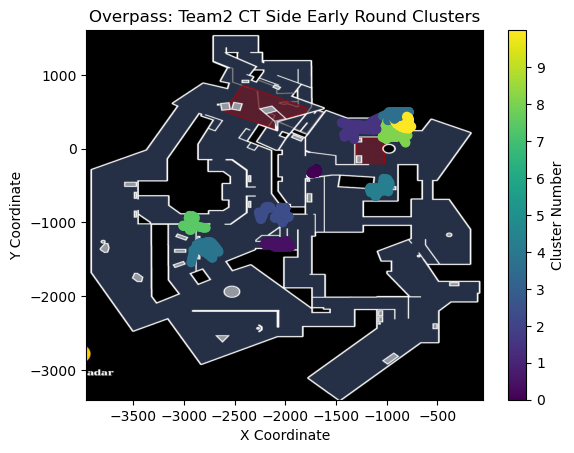

In [38]:
#load the image
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(top_cluster_df['x'], top_cluster_df['y'], c=top_cluster_df['cluster'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')

plt.colorbar(label='Cluster Number', ticks=range(10))
plt.clim(0, 10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Team2 CT Side Early Round Clusters')

# Display the plot
plt.show()

##### Mid Round:

In [39]:
# Mid Round: 35-80 seconds
mid_rounds = filtered_data[(filtered_data['seconds'] >= 35) & (filtered_data['seconds'] <= 80)].copy()
mid_rounds

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
66675,1,6927,CT,Team2,100,100,True,-1971,-1328,261,...,850,Connector,35,01:21,4,3,False,de_overpass,0.0,Player5
66676,1,6943,CT,Team2,100,100,True,-1971,-1328,261,...,850,Connector,35,01:21,4,3,False,de_overpass,0.0,Player5
66677,1,6959,CT,Team2,100,100,True,-1971,-1328,261,...,850,Connector,35,01:21,4,3,False,de_overpass,0.0,Player5
66678,1,6975,CT,Team2,100,100,True,-1971,-1328,261,...,850,Connector,35,01:21,4,3,False,de_overpass,0.0,Player5
66679,1,6991,CT,Team2,100,100,True,-1971,-1328,261,...,850,Connector,35,01:20,4,3,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210027,14,227214,CT,Team2,93,100,True,-580,-1383,144,...,5200,Canal,80,00:36,5,5,False,de_overpass,0.0,Player9
210028,14,227230,CT,Team2,93,100,True,-582,-1383,144,...,5200,Canal,80,00:35,5,5,False,de_overpass,0.0,Player9
210029,14,227246,CT,Team2,93,100,True,-593,-1382,144,...,5200,Canal,80,00:35,5,5,False,de_overpass,0.0,Player9
210030,14,227262,CT,Team2,93,100,True,-611,-1382,145,...,5200,Canal,80,00:35,5,5,False,de_overpass,0.0,Player9


In [40]:
# Perform Clustering
X = mid_rounds[['x', 'y']]
n_clusters = 60
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X)

mid_rounds['cluster'] = k_means.labels_
# Count the occurrences of each cluster label
cluster_counts = mid_rounds['cluster'].value_counts()
# print all the unique clusters
cluster_counts.unique()


array([921, 808, 670, 659, 615, 594, 563, 540, 512, 506, 484, 468, 443,
       431, 423, 422, 421, 419, 412, 389, 360, 356, 353, 329, 312, 303,
       302, 293, 291, 286, 264, 247, 237, 228, 223, 217, 214, 204, 195,
       189, 186, 183, 174, 154, 150, 144, 127, 126, 110, 109, 103, 102,
        98,  88,  83,  72,  62,  35], dtype=int64)

In [41]:
# Select the top five most common clusters
top_clusters = cluster_counts.head(10).index.tolist()
# Filter the DataFrame to include only the selected clusters
top_cluster_df = mid_rounds[mid_rounds['cluster'].isin(top_clusters)]
top_cluster_df

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,cluster
66688,1,7135,CT,Team2,100,100,True,-2035,-1314,303,...,Connector,36,01:19,4,3,False,de_overpass,0.0,Player5,11
66689,1,7151,CT,Team2,100,100,True,-2050,-1310,314,...,Connector,36,01:19,4,3,False,de_overpass,0.0,Player5,11
66690,1,7167,CT,Team2,100,100,True,-2065,-1307,324,...,Connector,36,01:19,4,3,False,de_overpass,0.0,Player5,11
66691,1,7183,CT,Team2,100,100,True,-2082,-1308,334,...,Connector,37,01:19,4,3,False,de_overpass,0.0,Player5,11
66692,1,7199,CT,Team2,100,100,True,-2097,-1312,344,...,Connector,37,01:19,4,3,False,de_overpass,0.0,Player5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207004,11,171163,CT,Team2,100,99,True,-2186,-1268,404,...,Connector,46,01:09,2,3,False,de_overpass,0.0,Player9,11
207005,11,171179,CT,Team2,100,99,True,-2200,-1268,413,...,Connector,46,01:09,2,3,False,de_overpass,0.0,Player9,11
207006,11,171195,CT,Team2,100,99,True,-2214,-1268,423,...,Connector,46,01:09,2,3,False,de_overpass,0.0,Player9,11
207007,11,171211,CT,Team2,100,99,True,-2228,-1268,432,...,Connector,46,01:09,2,3,False,de_overpass,0.0,Player9,11


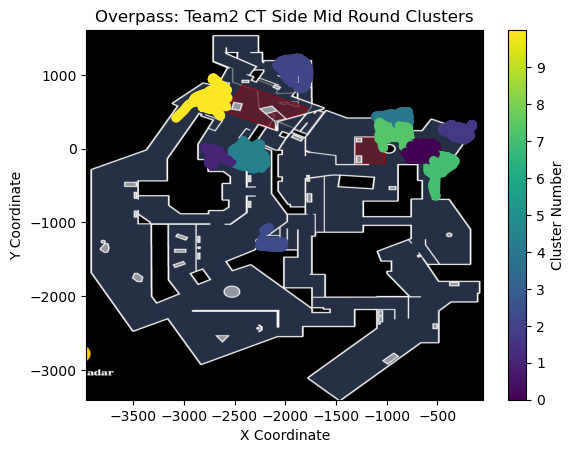

In [42]:
#load the image
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(top_cluster_df['x'], top_cluster_df['y'], c=top_cluster_df['cluster'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')

plt.colorbar(label='Cluster Number', ticks=range(10))
plt.clim(0, 10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Team2 CT Side Mid Round Clusters')

# Display the plot
plt.show()

##### Late Round:

In [43]:
# Late Round: 85-105 seconds
late_rounds = filtered_data[(filtered_data['seconds'] >= 80) & (filtered_data['seconds'] <= 105)].copy()
late_rounds

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
67035,1,12688,CT,Team2,100,100,True,-2313,-555,435,...,850,LowerPark,80,00:36,0,2,False,de_overpass,0.0,Player5
67036,1,12704,CT,Team2,100,100,True,-2345,-551,440,...,850,LowerPark,80,00:36,0,2,False,de_overpass,0.0,Player5
67037,1,12720,CT,Team2,100,100,True,-2376,-538,433,...,850,LowerPark,80,00:36,0,2,False,de_overpass,0.0,Player5
67038,1,12736,CT,Team2,100,100,True,-2389,-520,432,...,850,LowerPark,80,00:36,0,2,False,de_overpass,0.0,Player5
67039,1,12752,CT,Team2,100,100,True,-2389,-504,432,...,850,LowerPark,80,00:35,0,2,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210227,14,230414,CT,Team2,93,100,True,-2961,-2480,472,...,5200,Playground,105,00:11,2,4,False,de_overpass,0.0,Player9
210228,14,230430,CT,Team2,93,100,True,-2985,-2468,472,...,5200,Playground,105,00:10,2,4,False,de_overpass,0.0,Player9
210229,14,230446,CT,Team2,93,100,True,-3011,-2457,472,...,5200,Playground,105,00:10,2,4,False,de_overpass,0.0,Player9
210230,14,230462,CT,Team2,93,100,True,-3033,-2441,472,...,5200,Playground,105,00:10,2,4,False,de_overpass,0.0,Player9


In [44]:
# Perform Clustering
X = late_rounds[['x', 'y']]
n_clusters = 60
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X)

late_rounds['cluster'] = k_means.labels_
# Count the occurrences of each cluster label
cluster_counts = late_rounds['cluster'].value_counts()
# print all the unique clusters
cluster_counts.unique()

array([265, 257, 254, 248, 218, 213, 209, 208, 201, 200, 184, 165, 157,
       152, 121, 114, 102,  97,  96,  94,  83,  77,  73,  70,  67,  66,
        63,  62,  59,  56,  54,  52,  50,  49,  48,  47,  46,  44,  43,
        42,  41,  38,  35,  34,  32,  28,  26,  23,  18,  17,  14],
      dtype=int64)

In [45]:
# Select the top five most common clusters
top_clusters = cluster_counts.head(6).index.tolist()
# Filter the DataFrame to include only the selected clusters
top_cluster_df = late_rounds[late_rounds['cluster'].isin(top_clusters)]
top_cluster_df


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,cluster
68107,3,45263,CT,Team2,97,100,True,-2083,737,472,...,BombsiteA,80,00:36,4,4,False,de_overpass,0.0,Player5,43
68108,3,45279,CT,Team2,97,100,True,-2093,761,472,...,BombsiteA,80,00:36,4,4,False,de_overpass,0.0,Player5,43
68109,3,45295,CT,Team2,97,100,True,-2102,780,473,...,BombsiteA,80,00:36,4,4,False,de_overpass,0.0,Player5,43
68110,3,45311,CT,Team2,97,100,True,-2106,794,476,...,BombsiteA,80,00:36,4,4,False,de_overpass,0.0,Player5,43
68111,3,45327,CT,Team2,97,100,True,-2109,808,479,...,BombsiteA,80,00:35,4,4,False,de_overpass,0.0,Player5,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210192,14,229854,CT,Team2,93,100,True,-2007,-2543,444,...,Fountain,101,00:15,3,5,False,de_overpass,0.0,Player9,16
210193,14,229870,CT,Team2,93,100,True,-2036,-2551,448,...,Fountain,101,00:15,3,5,False,de_overpass,0.0,Player9,16
210194,14,229886,CT,Team2,93,100,True,-2061,-2562,449,...,Fountain,101,00:15,3,5,False,de_overpass,0.0,Player9,16
210195,14,229902,CT,Team2,93,100,True,-2089,-2566,453,...,Playground,101,00:15,3,5,False,de_overpass,0.0,Player9,16


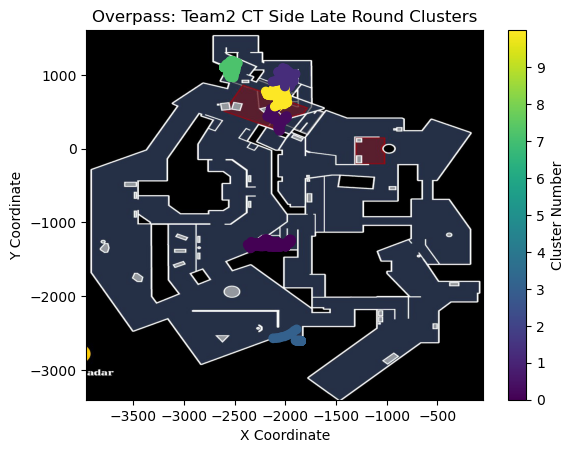

In [46]:
#load the image
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(top_cluster_df['x'], top_cluster_df['y'], c=top_cluster_df['cluster'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')

plt.colorbar(label='Cluster Number', ticks=range(10))
plt.clim(0, 10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Team2 CT Side Late Round Clusters')

# Display the plot
plt.show()

#### Strategy 2: Analyze CT player locations specifically within bombsiteB across different round phases

In [47]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()
# Load the data
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()

Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [48]:
x_min, x_max = game_state_df['x'].min(), game_state_df['x'].max()
y_min, y_max = game_state_df['y'].min(), game_state_df['y'].max()
# find min x and max y
print(f" X Min: {x_min}, X Max {x_max}")
print(f" Y Min: {y_min}, Y Max {y_max}")

 X Min: -3960, X Max -49
 Y Min: -3401, Y Max 1606


In [49]:
# Threating areas to consider when entering bombsite B
key_areas = ['BombsiteB', 'SnipersNest', 'Walkway']
# Apply initial filter
filtered_data = game_state_df[
    (game_state_df['team'] == 'Team2')
    & (game_state_df['side'] == 'CT')
    & (game_state_df['is_alive'] == True)
    & (game_state_df['bomb_planted'] == False)
    & (game_state_df['area_name'].isin(key_areas))
].copy()

filtered_data

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
66453,1,3375,CT,Team2,100,100,True,-1926,73,128,...,850,Walkway,7,01:49,5,5,False,de_overpass,0.0,Player5
66454,1,3391,CT,Team2,100,100,True,-1907,49,128,...,850,Walkway,7,01:49,5,5,False,de_overpass,0.0,Player5
66455,1,3407,CT,Team2,100,100,True,-1888,24,128,...,850,Walkway,7,01:48,5,5,False,de_overpass,0.0,Player5
66456,1,3423,CT,Team2,100,100,True,-1869,0,128,...,850,Walkway,7,01:48,5,5,False,de_overpass,0.0,Player5
66457,1,3439,CT,Team2,100,100,True,-1845,-19,128,...,850,Walkway,7,01:48,5,5,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209460,14,218142,CT,Team2,100,100,True,-1569,-112,128,...,5200,Walkway,9,01:46,5,5,False,de_overpass,0.0,Player9
209461,14,218158,CT,Team2,100,100,True,-1541,-121,128,...,5200,Walkway,9,01:46,5,5,False,de_overpass,0.0,Player9
209462,14,218174,CT,Team2,100,100,True,-1509,-132,128,...,5200,Walkway,9,01:46,5,5,False,de_overpass,0.0,Player9
209463,14,218190,CT,Team2,100,100,True,-1480,-141,128,...,5200,Walkway,9,01:46,5,5,False,de_overpass,0.0,Player9


##### Early Round:

In [50]:
# 15- 30 seconds
early_rounds = filtered_data[(filtered_data['seconds'] >= 15) & (filtered_data['seconds'] <= 30)].copy()
early_rounds

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
67677,3,38383,CT,Team2,97,100,True,-1052,-210,154,...,4550,BombsiteB,26,01:30,5,5,False,de_overpass,0.0,Player5
67678,3,38399,CT,Team2,97,100,True,-1079,-194,150,...,4550,BombsiteB,26,01:30,5,5,False,de_overpass,0.0,Player5
67689,3,38575,CT,Team2,97,100,True,-1415,-127,157,...,4550,Walkway,27,01:28,5,5,False,de_overpass,0.0,Player5
67690,3,38591,CT,Team2,97,100,True,-1447,-119,143,...,4550,Walkway,27,01:28,5,5,False,de_overpass,0.0,Player5
67691,3,38607,CT,Team2,97,100,True,-1477,-115,128,...,4550,Walkway,28,01:28,5,5,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205453,9,141228,CT,Team2,100,100,True,-1695,-303,230,...,5300,Walkway,30,01:26,5,5,False,de_overpass,0.0,Player9
205454,9,141244,CT,Team2,100,100,True,-1700,-307,230,...,5300,Walkway,30,01:25,5,5,False,de_overpass,0.0,Player9
205455,9,141260,CT,Team2,100,100,True,-1711,-316,230,...,5300,Walkway,30,01:25,5,5,False,de_overpass,0.0,Player9
205456,9,141276,CT,Team2,100,100,True,-1712,-317,230,...,5300,Walkway,30,01:25,5,5,False,de_overpass,0.0,Player9


In [51]:
# Perform Clustering
X = early_rounds[['x', 'y']]
n_clusters = 60
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X)

early_rounds['cluster'] = k_means.labels_
# Count the occurrences of each cluster label
cluster_counts = early_rounds['cluster'].value_counts()
cluster_counts.unique()

array([297, 244, 168, 121, 104,  88,  72,  70,  68,  57,  53,  46,  44,
        40,  39,  35,  32,  31,  30,  25,  24,  23,  21,  20,  19,  17,
        16,  15,  14,  13,  12,  11,  10,   9,   8,   7,   5], dtype=int64)

In [52]:
# Select the top five most common clusters
top_clusters = cluster_counts.head(10).index.tolist()
# Filter the DataFrame to include only the selected clusters
top_cluster_df = early_rounds[early_rounds['cluster'].isin(top_clusters)]
top_cluster_df


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,cluster
68480,4,53809,CT,Team2,100,100,True,-892,496,96,...,BombsiteB,19,01:36,4,5,False,de_overpass,0.0,Player5,0
68481,4,53825,CT,Team2,100,100,True,-864,496,96,...,BombsiteB,19,01:36,4,5,False,de_overpass,0.0,Player5,0
68482,4,53841,CT,Team2,100,100,True,-847,496,96,...,BombsiteB,19,01:36,4,5,False,de_overpass,0.0,Player5,0
68483,4,53857,CT,Team2,100,100,True,-841,495,96,...,BombsiteB,19,01:36,4,5,False,de_overpass,0.0,Player5,33
68484,4,53873,CT,Team2,100,100,True,-840,495,96,...,BombsiteB,20,01:36,4,5,False,de_overpass,0.0,Player5,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205453,9,141228,CT,Team2,100,100,True,-1695,-303,230,...,Walkway,30,01:26,5,5,False,de_overpass,0.0,Player9,5
205454,9,141244,CT,Team2,100,100,True,-1700,-307,230,...,Walkway,30,01:25,5,5,False,de_overpass,0.0,Player9,5
205455,9,141260,CT,Team2,100,100,True,-1711,-316,230,...,Walkway,30,01:25,5,5,False,de_overpass,0.0,Player9,44
205456,9,141276,CT,Team2,100,100,True,-1712,-317,230,...,Walkway,30,01:25,5,5,False,de_overpass,0.0,Player9,44


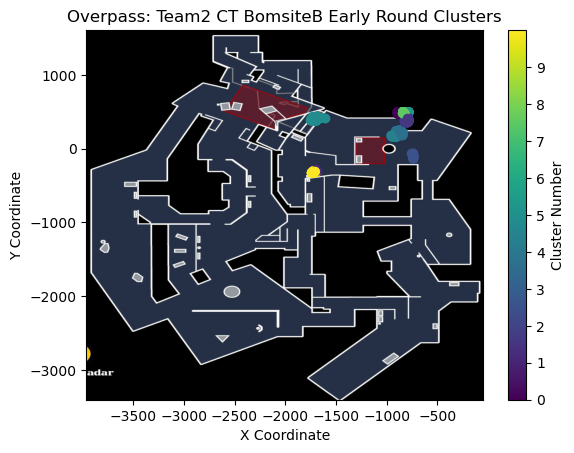

In [53]:
#load the image
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(top_cluster_df['x'], top_cluster_df['y'], c=top_cluster_df['cluster'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')

plt.colorbar(label='Cluster Number', ticks=range(10))
plt.clim(0, 10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Team2 CT BomsiteB Early Round Clusters')

# Display the plot
plt.show()

##### Mid Round:

In [54]:
# Mid Round: 35-80 seconds
mid_rounds = filtered_data[(filtered_data['seconds'] >= 35) & (filtered_data['seconds'] <= 80)].copy()
mid_rounds

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
68604,4,55793,CT,Team2,100,100,True,-832,496,96,...,4250,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5
68605,4,55809,CT,Team2,100,100,True,-832,496,96,...,4250,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5
68606,4,55825,CT,Team2,100,100,True,-832,496,96,...,4250,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5
68607,4,55841,CT,Team2,100,100,True,-832,496,96,...,4250,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5
68608,4,55857,CT,Team2,100,100,True,-832,496,96,...,4250,BombsiteB,35,01:20,4,5,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205617,9,143852,CT,Team2,100,100,True,-1911,19,128,...,5300,Walkway,50,01:05,4,5,False,de_overpass,0.0,Player9
205618,9,143868,CT,Team2,100,100,True,-1927,46,128,...,5300,Walkway,51,01:05,4,5,False,de_overpass,0.0,Player9
205619,9,143884,CT,Team2,100,100,True,-1943,73,128,...,5300,Walkway,51,01:05,4,5,False,de_overpass,0.0,Player9
205620,9,143900,CT,Team2,100,100,True,-1960,99,128,...,5300,Walkway,51,01:05,4,5,False,de_overpass,0.0,Player9


In [55]:
# Perform Clustering
X = mid_rounds[['x', 'y']]
n_clusters = 60
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X)

mid_rounds['cluster'] = k_means.labels_
# print all the unique clusters
# Count the occurrences of each cluster label
cluster_counts = mid_rounds['cluster'].value_counts()
cluster_counts.unique()


array([264, 259, 252, 237, 176, 140, 133, 127, 123, 113,  95,  91,  84,
        79,  75,  74,  65,  57,  56,  55,  54,  51,  49,  47,  46,  42,
        39,  34,  33,  32,  31,  29,  27,  26,  24,  23,  22,  21,  20,
        19,  16,  15,  13,  12,   5], dtype=int64)

In [56]:
# Select the top five most common clusters
top_clusters = cluster_counts.head(10).index.tolist()
# Filter the DataFrame to include only the selected clusters
top_cluster_df = mid_rounds[mid_rounds['cluster'].isin(top_clusters)]
top_cluster_df

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,cluster
68604,4,55793,CT,Team2,100,100,True,-832,496,96,...,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5,14
68605,4,55809,CT,Team2,100,100,True,-832,496,96,...,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5,14
68606,4,55825,CT,Team2,100,100,True,-832,496,96,...,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5,14
68607,4,55841,CT,Team2,100,100,True,-832,496,96,...,BombsiteB,35,01:21,4,5,False,de_overpass,0.0,Player5,14
68608,4,55857,CT,Team2,100,100,True,-832,496,96,...,BombsiteB,35,01:20,4,5,False,de_overpass,0.0,Player5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205601,9,143596,CT,Team2,100,100,True,-1689,-307,230,...,Walkway,48,01:07,4,5,False,de_overpass,0.0,Player9,17
205602,9,143612,CT,Team2,100,100,True,-1696,-307,230,...,Walkway,49,01:07,4,5,False,de_overpass,0.0,Player9,17
205603,9,143628,CT,Team2,100,100,True,-1702,-299,230,...,Walkway,49,01:07,4,5,False,de_overpass,0.0,Player9,17
205604,9,143644,CT,Team2,100,100,True,-1715,-283,230,...,Walkway,49,01:07,4,5,False,de_overpass,0.0,Player9,17


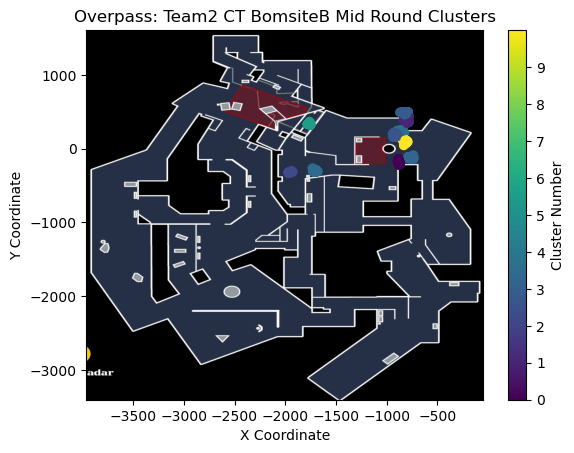

In [57]:
#load the image
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(top_cluster_df['x'], top_cluster_df['y'], c=top_cluster_df['cluster'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')

plt.colorbar(label='Cluster Number', ticks=range(10))
plt.clim(0, 10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Team2 CT BomsiteB Mid Round Clusters')

# Display the plot
plt.show()

##### Late Round:

In [58]:
# Late Round: 85-105 seconds
late_rounds = filtered_data[(filtered_data['seconds'] >= 80) & (filtered_data['seconds'] <= 105)].copy()
late_rounds

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
69374,5,70672,CT,Team2,15,95,True,-1743,-141,128,...,5700,Walkway,80,00:36,2,4,False,de_overpass,0.0,Player5
69375,5,70688,CT,Team2,15,95,True,-1732,-132,128,...,5700,Walkway,80,00:36,2,4,False,de_overpass,0.0,Player5
69376,5,70704,CT,Team2,15,95,True,-1721,-124,128,...,5700,Walkway,80,00:36,2,4,False,de_overpass,0.0,Player5
69377,5,70720,CT,Team2,15,95,True,-1712,-113,128,...,5700,Walkway,80,00:36,2,4,False,de_overpass,0.0,Player5
69378,5,70736,CT,Team2,15,95,True,-1701,-105,128,...,5700,Walkway,80,00:35,2,4,False,de_overpass,0.0,Player5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185148,11,175596,CT,Team2,100,99,True,-887,-88,134,...,5900,BombsiteB,81,00:35,0,3,False,de_overpass,0.0,Player8
185149,11,175612,CT,Team2,100,99,True,-893,-91,138,...,5900,BombsiteB,81,00:35,0,3,False,de_overpass,0.0,Player8
185150,11,175628,CT,Team2,100,99,True,-898,-94,128,...,5900,BombsiteB,81,00:35,0,3,False,de_overpass,0.0,Player8
185151,11,175644,CT,Team2,100,99,True,-903,-96,108,...,5900,BombsiteB,81,00:34,0,3,False,de_overpass,0.0,Player8


In [59]:
# Perform Clustering
X = late_rounds[['x', 'y']]
n_clusters = 60
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X)

late_rounds['cluster'] = k_means.labels_
# print all the unique clusters
# Count the occurrences of each cluster label
cluster_counts = late_rounds['cluster'].value_counts()
cluster_counts.unique()

array([168,  75,  73,  49,  44,  42,  32,  23,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2], dtype=int64)

In [60]:
# Select the top five most common clusters
top_clusters = cluster_counts.head(6).index.tolist()
# Filter the DataFrame to include only the selected clusters
top_cluster_df = late_rounds[late_rounds['cluster'].isin(top_clusters)]
top_cluster_df


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,cluster
69418,5,71376,CT,Team2,15,95,True,-1958,-318,128,...,Walkway,85,00:30,2,4,False,de_overpass,0.0,Player5,3
69419,5,71392,CT,Team2,15,95,True,-1963,-325,128,...,Walkway,85,00:30,2,4,False,de_overpass,0.0,Player5,3
69420,5,71408,CT,Team2,15,95,True,-1968,-331,128,...,Walkway,85,00:30,2,4,False,de_overpass,0.0,Player5,3
69421,5,71424,CT,Team2,15,95,True,-1968,-335,128,...,Walkway,85,00:30,2,4,False,de_overpass,0.0,Player5,3
69422,5,71440,CT,Team2,15,95,True,-1968,-335,128,...,Walkway,86,00:30,2,4,False,de_overpass,0.0,Player5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136808,6,93742,CT,Team2,100,100,True,-790,376,147,...,BombsiteB,89,00:27,2,4,False,de_overpass,0.0,Player6,7
136809,6,93758,CT,Team2,100,100,True,-790,376,147,...,BombsiteB,89,00:26,2,4,False,de_overpass,0.0,Player6,7
136810,6,93774,CT,Team2,100,100,True,-790,376,147,...,BombsiteB,89,00:26,2,4,False,de_overpass,0.0,Player6,7
136811,6,93790,CT,Team2,100,100,True,-791,378,147,...,BombsiteB,89,00:26,2,4,False,de_overpass,0.0,Player6,7


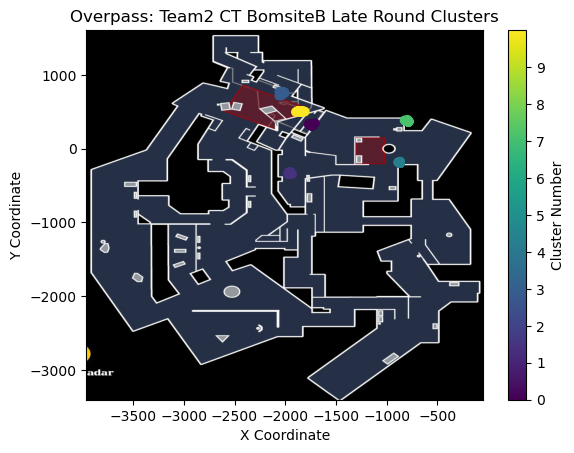

In [61]:
#load the image
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(top_cluster_df['x'], top_cluster_df['y'], c=top_cluster_df['cluster'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')

plt.colorbar(label='Cluster Number', ticks=range(10))
plt.clim(0, 10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Team2 CT BomsiteB Late Round Clusters')

# Display the plot
plt.show()

#### Conclusion:

- Since this section's solution mostly involes visual aid, please view the heatmaps above
**Note:** 
- The player location points may have slight inaccuraces since the image isn't scaled perfectly
- Since this a 2d plot, the z-axis is ignored which may provide inaccuraces
    - Though this shouldn't impact the analysis too much since players can quickly rotate up and down the stairs in the map, Overpass

***

## Part 3

> Most of the time, our stakeholders (in this case, the CS:GO coaching staff) aren’t tech-savvy enough to run code themselves. Propose a solution to your product manager that:

> a. could allow our coaching staff to request or acquire the output themselves

> b. takes less than 1 weeks worth of work to implement

#### Service and GUI Platform Selection

1. What service is required to allow the coaching staff to request or acquire the output themselves?
   - To present data in an intuitive manner, a GUI (Graphical User Interface) is needed.

2. What GUI platform would allow the coaching staff to view the data analytics in a meaningful and easy-to-use manner?
   - Mobile App:
     - Pros: Easy access on mobile devices, convenient for on-the-go use.
     - Cons:
       - May require additional development effort and maintenance for multiple mobile platforms (iOS, Android).
       - May not be suitable for coaches to use since they may want to view the data analytics in a larger viewing platform.
   - Web Application:
     - Pros: Accessibility on any device, easy deployment, no platform-specific development required.
     - Cons: May require an internet connection for access.
   - Desktop Application:
     - Pros: Full control over the application and user experience, potentially more powerful features.
     - Cons: Platform-specific development required, limited to specific operating systems.
   - Analysis Reporting:
     - Pros: The Data Scientist can create a customized report that suits the coach's needes
     - Cons: Relies on the Data Scientist to be available at all time, can waste time for both parties

3. Let's choose a Web Application.
   - Accessibility on any device.
   - The ability to resolve most technical issues through software engineering.

4. Since a web application is selected, let's explore modern-day tools for integrating it.
   - Flask/ReactJS:
     - Pros: Easy integration of backend (Flask) and frontend (ReactJS), flexible development options.
     - Cons: Requires knowledge of both Flask and ReactJS.
   - Django:
     - Pros: Full-stack web development framework, rapid development with built-in components.
     - Cons: May have a steeper learning curve for non-Django developers.
   - Streamlit:
     - Pros: Rapid development of interactive data analytics applications, simple and intuitive interface, excellent data visualization capabilities.
     - Cons: Limited flexibility for complex applications, may require additional customization for specific needs.

5. Let's choose Streamlit.
   - Streamlit is a powerful web application framework that enables quick development of interactive data analytics applications.
   - It offers a simple and intuitive interface for presenting data in a meaningful and easy-to-use manner.
   - With Streamlit, the coaching staff can access the data analytics output and interact with it seamlessly.
   - It provides excellent data visualization capabilities, making it suitable for presenting CS:GO analytics.
   - Streamlit is known for its ease of use and rapid development, which aligns with the one-week implementation timeline.
   - By choosing Streamlit, we can ensure that the coaching staff can conveniently request and acquire the data analytics output themselves while keeping the development time within the desired timeframe.

## Assesment End: This point marks the official end of the assessment

**Final Thoughts:** Hello EG Team, I had a great time working with the CS:GO dataset. I would be thrilled to do game analytics for the EG CS:GO team in the future, as it allowed me to explore my creative side, leverage my game knowledge, and apply data science techniques to derive valuable insights. Once again, thank you for considering my application. 

*On a side note*, congratulations to the EG Valorant team for qualifying for Masters Tokyo.


## Experimentation

**Note:** This section is **not** part of the assessment. I just wanted to explore how the players move around the map, feel free to take a look.

In [62]:
# Enter Current File Path
file_path = "game_state_frame_data.parquet"

# Create an instance of ProcessGameState
process_game_state = ProcessGameState()
# Load the data and set the respective boundaries
game_state_df = process_game_state.load_data(file_path=file_path)

game_state_df.head()

Created Class


,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,900,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player0
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,900,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player0


In [63]:
x_min, x_max = game_state_df[(game_state_df['is_alive'] == True)]['x'].min(), game_state_df[(game_state_df['is_alive'] == True)]['x'].max()
y_min, y_max = game_state_df[(game_state_df['is_alive'] == True)]['y'].min(), game_state_df[(game_state_df['is_alive'] == True)]['y'].max()
# y_min, y_max = game_state_df['y'].min(), game_state_df['y'].max()
# find min x and max y
print(f" X Min: {x_min}, X Max {x_max}")
print(f" Y Min: {y_min}, Y Max {y_max}")

 X Min: -3960, X Max -49
 Y Min: -3401, Y Max 1606


In [64]:
# Track player one movement throughout the round
player1_round1_df = game_state_df[
    (game_state_df['round_num'] == 1)
    & (game_state_df['player'] == 'Player1')
    & (game_state_df['is_alive'] == True)
    & (game_state_df['bomb_planted'] == False)
].copy()

player1_round1_df

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,equipment_value_freezetime_end,area_name,seconds,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player
22133,1,2511,T,Team1,100,100,True,-1452,-3334,296,...,850,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player1
22134,1,2527,T,Team1,100,100,True,-1445,-3323,296,...,850,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player1
22135,1,2543,T,Team1,100,100,True,-1434,-3305,295,...,850,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player1
22136,1,2559,T,Team1,100,100,True,-1419,-3282,294,...,850,TSpawn,0,01:55,5,5,False,de_overpass,0.0,Player1
22137,1,2575,T,Team1,100,100,True,-1404,-3257,293,...,850,TSpawn,1,01:55,5,5,False,de_overpass,0.0,Player1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22439,1,7407,T,Team1,100,100,True,-2889,786,480,...,850,BombsiteA,38,01:17,4,3,False,de_overpass,0.0,Player1
22440,1,7423,T,Team1,100,100,True,-2861,777,480,...,850,BombsiteA,38,01:17,4,3,False,de_overpass,0.0,Player1
22441,1,7439,T,Team1,100,100,True,-2836,764,480,...,850,BombsiteA,39,01:17,4,3,False,de_overpass,0.0,Player1
22442,1,7455,T,Team1,100,100,True,-2811,751,480,...,850,BombsiteA,39,01:17,4,3,False,de_overpass,0.0,Player1


X Min: -3960, X Max: -49
Y Min: -3401, Y Max: 1606


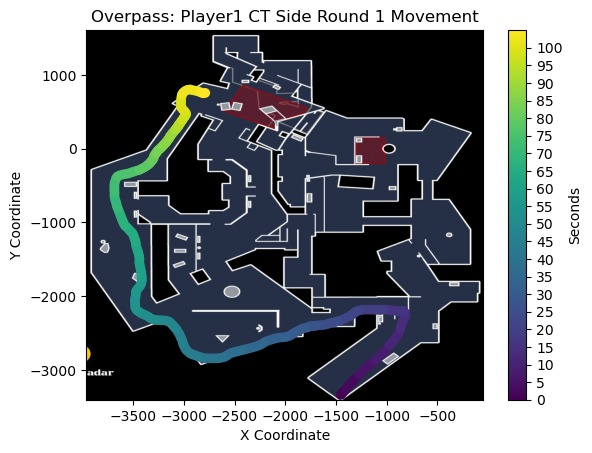

In [69]:
# Plot the player's movement
overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')

plt.scatter(player1_round1_df['x'], player1_round1_df['y'], c=player1_round1_df['seconds'], cmap='viridis', marker='o')

plt.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')
# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Overpass: Player1 CT Side Round 1 Movement')
# Color bar labels
plt.colorbar(label='Seconds', ticks=range(0, 105, 5))
plt.clim(0, 105)
# print x_min, x_max, y_min, y_max with given labels
print(f"X Min: {x_min}, X Max: {x_max}")
print(f"Y Min: {y_min}, Y Max: {y_max}")


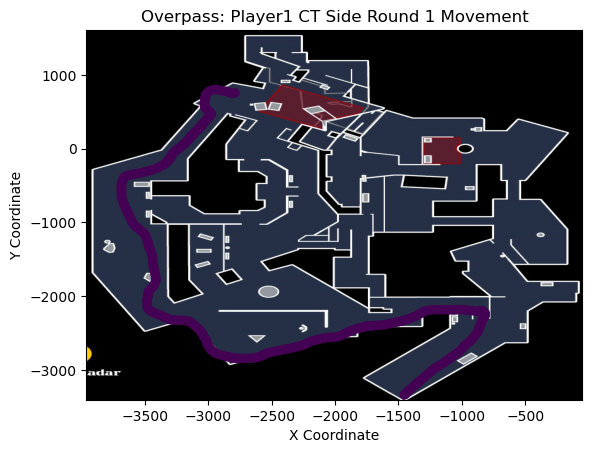

In [71]:
import matplotlib.animation as animation

overpass_img = mpimg.imread('crop_de_overpass_radar.jpeg')
# Create a figure and axis for the animation
fig, ax = plt.subplots()

ax.imshow(overpass_img, extent=[x_min, x_max, y_min, y_max], aspect='auto')
# Set up the initial scatter plot
scatter = ax.scatter([], [], c=[], cmap='viridis', marker='o')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.title('Overpass: Player1 CT Side Round 1 Movement')

# Define the update function for the animation
def update_frame(i):
    frame_data = player1_round1_df[player1_round1_df['seconds'] <= i]
    scatter.set_offsets(frame_data[['x', 'y']])
    scatter.set_array(frame_data['seconds'])
    return scatter,

# Create the animation
animation_frames = int(player1_round1_df['seconds'].max()) + 1  # Number of frames for the animation
ani = animation.FuncAnimation(fig, update_frame, frames=animation_frames, interval=200)

# Save the animation as a video file
ani.save('player_movement_animation.gif', writer='pillow')

# Display the animation
plt.show()